# Text classification of Voice Commands
### Sections:
* [1. Load datasets](#section1)
* [2. Different model for classification](#section2)
    * [2.1 Naive Bayes](#section2.1)
    * [2.2 Logistic Regression](#section2.2)
* [3. Model Evaluation](#section3)
* [4. Save model](#section4)

Some useful imports:

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pprint import pprint

import pickle

%matplotlib inline

Fix random seed:

In [2]:
np.random.seed(1234)

# 1. Load the data

In [3]:
data = pd.read_csv('500k.csv',sep='\t',header=None, names=['INN', 'KPP','Type','Description'])
data.drop(['INN', 'KPP'], axis=1, inplace=True)
data = pd.DataFrame({'Type': np.array(data['Type'], dtype='int'), 'Description': np.array(data['Description'])})
data = data[['Type', 'Description']]

In [4]:
print('Data size: ', data.shape)
data.head()

Data size:  (500000, 2)


,Type,Description
0,4022,Предоплата за поверку СИ по счетам N 140808 от...
1,4022,Оплата услуг по договору N40077 от 9 февраля 2...
2,4022,"Aвансовый платеж за услугибульдозеров SD32, CA..."
3,3001,Оплата за Проектные работыи предпроектные прор...
4,4018,предоплата за рекламу в газете и на сайте Ком...


In [5]:
data.dropna(inplace=True)
print('Data size: ', data.shape)

Data size:  (498135, 2)


In [6]:
X = np.array(data['Description'])
y = np.array(data['Type'], dtype = 'int')

# 2. Data analysis

In [7]:
print('The number of classes: ', len(np.unique(y)))
unique, counts = np.unique(y, return_counts=True)
data_dict = dict(zip(unique, counts))

The number of classes:  133


In [8]:
def idx_by_count(count):
    return np.where(np.array(list(data_dict.values())) == count)[0]

def key_by_count(count):
    return np.array(list(data_dict.items()))[:,0][idx_by_count(count)]

Plot now a diagram of interclass distribution:

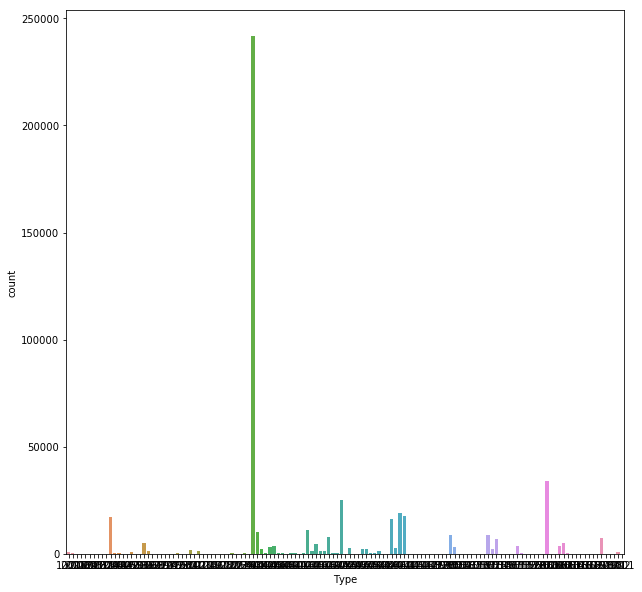

In [9]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data)

We see that we have 25% of our data belonging to one class, which means that our data is strongly unbalanced. Find this class:

In [10]:
print("Most populated class is: ", key_by_count(counts.max()))

Most populated class is:  [3001]


Delete 75% of this class instances:

In [11]:
data_cleared= data.drop(data[data.Type==3001].index[::2], inplace=False)
data_cleared = data_cleared.drop(data_cleared[data_cleared.Type==3001].index[::2], inplace=False)

In [12]:
data_cleared.shape

(316831, 2)

In [13]:
data_3001_1 = data.drop(data[data.Type == 3001].index[1::2], inplace=False)
data_3001_2 = data_3001_1.drop(data_3001_1[data_3001_1.Type == 3001].index[1::2], inplace=False)
data_3001_1 = data_3001_1[data_3001_1.Type == 3001].copy()
data_3001_2 = data_3001_2[data_3001_2.Type == 3001].copy()
data_3001 = pd.concat([data_3001_1, data_3001_2], axis=0, join='inner')

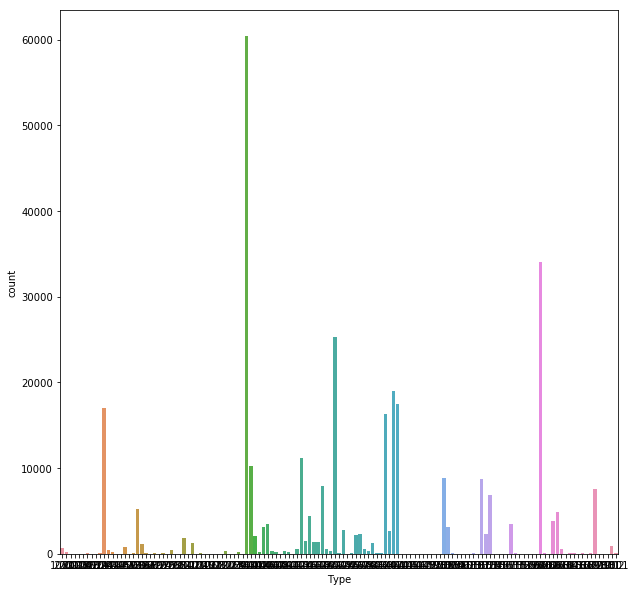

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared)

And we have several classes that are very rare:

In [15]:
print("Classes with only 1 sample: ", key_by_count(1))

Classes with only 1 sample:  [2011 2047 2074 2084 2120 2129 4105 4117 5010 5125 6218]


In [16]:
data[data.Type == 2074].Description[88205]

'Возврат по рассрочке платежа по договору купли-продажи согласно заявления клиента на периодическое перечисление денежных средств от 09.12.2015 г. Без НДС№REF45<<ИМЯ>ПАО  ЛИПЕЦККОМБАНК //НЕСТЕРЕНКО АННА АЛЕКСЕЕВНА//40817810300007041311//398036 ЛИПИНН=4825005381КПП=482501001'

In [17]:
print("Classes with only 2 sample: ", key_by_count(2))

Classes with only 2 sample:  [2002 2110 2127 4110 5105]


Delete the entries in data with the total number of a class less than 10:

In [18]:
def delete_minor_classes(data, min_count = 10):
    data_copy = data.copy()
    for i in range(1, min_count + 1):
        classes = key_by_count(i)
        for class_name in classes:
            data_copy.drop(data_copy[data_copy.Type==class_name].index, inplace=True)
    return data_copy

In [19]:
data_cleared = delete_minor_classes(data_cleared, 10)

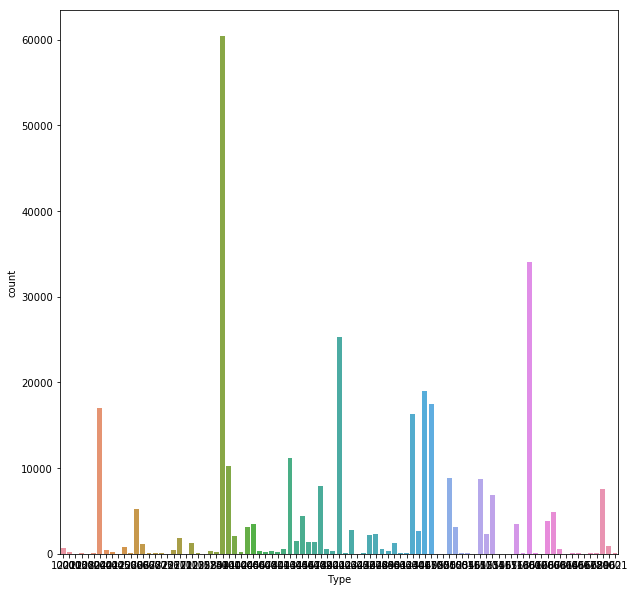

In [20]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared)

# 3. Preprocessing and training pipeline

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

## 3.1 Straigth-forward classification

Split the data into train and test sets:

In [22]:
test_size = 0.2
X = np.array(data['Description'])
y = np.array(data['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [23]:
parameters = {'vect__ngram_range': [(1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-3, 1e-6, 1e-1),
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='log', penalty='l2',
                                           alpha=1e-3, random_state=1234,
                                           max_iter=6, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=True)

Train a classifier:

In [ ]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\i344436\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Compute the accuracy:

In [ ]:
gs_clf.best_params_

In [ ]:
gs_clf.best_score_

If we use the initial data set, the resulting accuracy is much worse:

In [ ]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

## 3.2 Classification using cleared data

As we have seen, our data is highly unbalanced, thus we can try to use cleared data, where the most populated class is reduced.

Split the data into train and test sets:

In [24]:
data_ = data_cleared.copy()

In [25]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X = np.array(data_['Description'])
y = np.array(data_['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [26]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-5, 1e-6, 1e-7,1e-8),
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='log', penalty='l2',
                                           alpha=1e-3, random_state=1234,
                                           max_iter=5, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=True)

Train a classifier:

In [ ]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Compute the accuracy:

In [ ]:
gs_clf.best_params_

In [ ]:
gs_clf.best_score_

In [ ]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

## 3.3 Classification without duplicates in data

In [27]:
data_cleared.shape

(316675, 2)

In [28]:
data_wh_dup = data_cleared.drop_duplicates(subset=['Description'], inplace=False)
data_wh_dup.shape

(263201, 2)

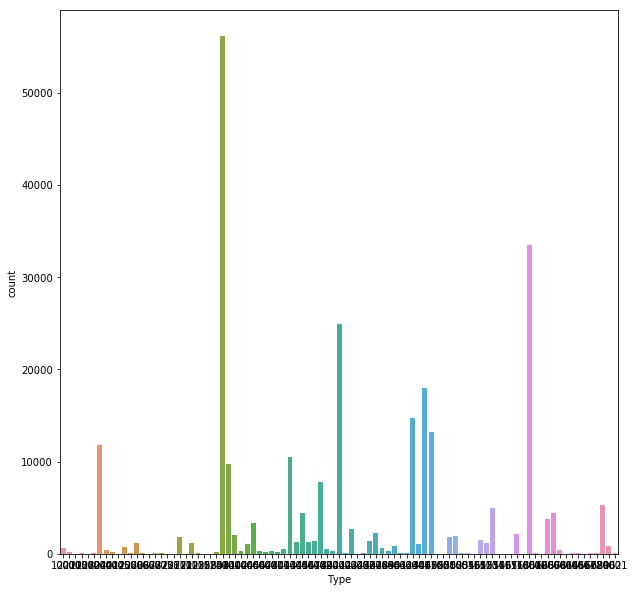

In [29]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_wh_dup)

In [30]:
test_size = 0.2
X = np.array(data_wh_dup['Description'])
y = np.array(data_wh_dup['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [67]:
parameters = {'vect__ngram_range': [(1,3), (1,4)],
              'vect__min_df': (1e-20, 1e-10),
              #'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-3, 1e-6)
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer(norm='l1', use_idf=True)),
                     ('clf', SGDClassifier(loss='log', penalty='l1',
                                           random_state=1234,
                                           max_iter=5, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=5)

Train a classifier:

In [ ]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


Compute the accuracy:

In [ ]:
gs_clf.best_params_

In [ ]:
gs_clf.best_score_

In [ ]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

### 3.4 TEST

In [31]:
test_size = 0.2
X = np.array(data_wh_dup['Description'])
y = np.array(data_wh_dup['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [32]:
parameters = {'vect__ngram_range': [(1,3)],
              'clf__alpha': (1e-1, 1e-7)
}

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     ('clf', SGDClassifier(loss='log', penalty='l1',
                                           random_state=1234,
                                           max_iter=5, tol=None, n_jobs=-1)),
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=2)

Train a classifier:

In [33]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  8.5min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 13.3min finished


Compute the accuracy:

In [34]:
gs_clf.best_params_

{'clf__alpha': 1e-07, 'vect__ngram_range': (1, 3)}

In [35]:
gs_clf.best_score_

0.94602013677811547

In [36]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

Accuracy on the train:  0.999097644377
Accuracy on the test:  0.948937140252


# 3. Model Analysis

Some useful function:

In [37]:
def class_by_idx(data, index):
    y = np.array(data['Type'], dtype = 'int')
    unique, counts = np.unique(y, return_counts=True)
    data_dict = dict(zip(unique, counts))
    return np.array(list(data_dict.keys()))[index]

def find_most_probable_class(data, probabilities, n_classes=2):
    probabilities = probabilities[0]
    sorted_prob = np.sort(probabilities)
    idx_sorted_prob = probabilities.argsort()
    return class_by_idx(data, idx_sorted_prob[-n_classes:][::-1]), sorted_prob[-n_classes:][::-1]

In [38]:
y_pred = best_clf.predict(X_test)

mistakes = np.array([i for i in range(len(y_pred)) if (y_pred[i] != y_test[i])])

In [39]:
mistakes[:5]

array([ 9, 14, 55, 79, 80])

### Consider several difficult cases:

### 1. Similar entries - different classes

We see that our classifier confuses **4028** and **3001** classes, and in our data we have several entries, which belong to that classes:

In [40]:
entry = 'Арендная плата за ноябрь 2015г по ДАЗУ 45-ю от 20.02.2007г. НДС не облагается№REF<<ИМЯ>ИНН=6646001507КПП=664601001'
data_cleared[data_cleared.Description == entry]

,Type,Description
451389,3001,Арендная плата за ноябрь 2015г по ДАЗУ 45-ю от...


In [41]:
probs = best_clf.predict_proba([X_test[3]])

In [42]:
find_most_probable_class(data_cleared, probs, 2)

(array([4028, 4022]), array([  9.99602364e-01,   2.26862942e-04]))

In [43]:
entry = 'Арендная плата за октябрь 2013г. по ДАЗУ 33 от 13.12.2005 НДС не облагается<<ИМЯ>УФК по Свердловской области (МУГИСО)ИНН=6658091960КПП=667001001'
data_cleared[data_cleared.Description == entry]

,Type,Description
450747,4028,Арендная плата за октябрь 2013г. по ДАЗУ 33 от...


### 2. Abbreviations

In [44]:
X_test[7]

'Гос. пошлина за перегистрацию автомобиля НДС не облагается№REF18263<<ИМЯ>УФК по Свердловской области (УМВД России по г.Екатеринбургу, л/сч 04621052830)ИНН=6661014613КПП=666101001'

In [45]:
j = 7
print(str(X_test[j]) + '\ntrue: ' + str(y_test[j]) + '\npred: ' + str(y_pred[j]))

Гос. пошлина за перегистрацию автомобиля НДС не облагается№REF18263<<ИМЯ>УФК по Свердловской области (УМВД России по г.Екатеринбургу, л/сч 04621052830)ИНН=6661014613КПП=666101001
true: 4017
pred: 4017


In [46]:
prob = best_clf.predict_proba([X_test[j]])
find_most_probable_class(data_cleared, prob, j)

(array([4017, 3001, 4022, 4040, 4018, 4023, 4020]),
 array([  9.63890289e-01,   2.67942615e-02,   8.37689921e-03,
          5.37040076e-04,   5.56939273e-05,   1.52984657e-05,
          1.26805556e-05]))

### 3. Similar classes


The first thing to consider is that classes **2101** and **2103** are pretty similar:

And our classifier works fine:

In [47]:
def lazy_print(idx):
    print('%r => %s, true: %s' % (X_test[idx], best_clf.predict([X_test[idx]]),y_test[idx]))

In [48]:
lazy_print(12)

'{VO99090}Возмещение денежных средств по операциям с использованием банковских карт, общая сумма 161.14, комиссия 0.48. Без НДС. Согласно договора№REF179<<ИМЯ>ПАО  ЛИПЕЦККОМБАНКИНН=4825005381КПП=' => [5107], true: 5107


In [49]:
find_most_probable_class(data_cleared, best_clf.predict_proba([X_test[12]]), n_classes=3)

(array([5107, 4041, 2101]), array([ 0.66304269,  0.32975692,  0.00396339]))

In [50]:
mistakes.shape

(2688,)

### 4. Other mistakes

In [51]:
mistakes

array([    9,    14,    55, ..., 52618, 52624, 52640])

In [52]:
lazy_print(9)

'Списание долларов США для продажи согласно заявки №41от 02.04.2012г.№REF43164259<<ИМЯ>ИНН=7729405872' => [4060], true: 5004


In [53]:
entry = 'Списание долларов США для продажи согласно заявки №67от 01.03.2012г.№REF40740894<<ИМЯ>ИНН=7729405872'
data_cleared[data_cleared.Description == entry]

,Type,Description
132448,5004,Списание долларов США для продажи согласно зая...


In [54]:
probs = best_clf.predict_proba([data_cleared.iloc[132448].Description])

In [55]:
find_most_probable_class(data_cleared, probs, 2)

(array([5102, 5002]), array([ 0.98543253,  0.01436979]))

In [56]:
entry = 'Арендная плата за октябрь 2013г. по ДАЗУ 33 от 13.12.2005 НДС не облагается<<ИМЯ>УФК по Свердловской области (МУГИСО)ИНН=6658091960КПП=667001001'
data_cleared[data_cleared.Description == entry]

,Type,Description
450747,4028,Арендная плата за октябрь 2013г. по ДАЗУ 33 от...


In [57]:
best_clf.predict_proba(["Aвансовый платеж по дог.NA2100252 от 01.03.2010г.на продажу авиа и ж/д билетов Вт.ч. НДС 18%- 38135-59№REF71639<<ИМЯ>ФГУП  ГлавУпДК при МИД РоссииИНН=7704010978КПП=774801001"]).max()

0.99634748555675157

In [58]:
best_clf.predict_proba(['Из ЗП Ястребцовой С. А. заянварь 2012 г. оплата по договору купли-продажи гаражного бокса N5/824 от 29.04.2011 НДС не облагается<<ИМЯ>Филиал ОАО  НЛМК  в г.Екатеринбурге- НЛМК-УралИНН=4823006703КПП=665843001']).max()

0.95824253348861776

In [59]:
best_clf.predict(['Оплата за вкладыш в трудовую книжку Болонь Никита Евгеньевич НДС не облагается№REF435<<ИМЯ>ИНН=6646009256КПП=662701001'])

array([3001])

### 5. Save model

In [60]:
pickle.dump(best_clf, open( "clf.pkl", "wb" ) )

### 6. Load model

In [61]:
clf = pickle.load(open( "clf.pkl", "rb") )

In [62]:
clf.predict(['закрой че нить'])

array([3001])

In [63]:
labels = np.zeros(4)
probs = clf.predict_proba(['открой и закрой пожалуйста что нить'])[0]